In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import re
import nltk
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import indian
from nltk.stem.porter import PorterStemmer
# from wordcloud import WordCloud
import matplotlib.pyplot as plt
import unicodedata
from keras.models import Sequential,Model
from keras.layers import Input,Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
import string
# import spacy
# import contractions
from nltk.corpus import stopwords
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
df_en = pd.read_table('data/all.tok.test.en',header=None, names=['English'])
df_th = pd.read_table('data/all.tok.test.th', header=None, names=['Thai'])

In [3]:
df_en["English"] = df_en["English"].str[1:]
df_en["English"] = df_en["English"].str.lower()

df_en["English"] = df_en["English"].str.replace('&quot;', '')
df_en["English"] = df_en["English"].str.replace('&apos;', '')
df_en["English"] = df_en["English"].str.replace('&amp; lt ;', '')
df_en["English"] = df_en["English"].str.replace('&amp; gt ;', '')
df_en["English"] = df_en["English"].str.replace('&amp;', 'and')
df_en["English"] = df_en["English"].str.replace('&#91;', '')
df_en["English"] = df_en["English"].str.replace('&#93;', '')

chars_to_remove = r'[|/\\*“”\-_~^#?.!,:;\"\'()\[\]{}<>]'
df_en["English"] = df_en["English"].str.replace(chars_to_remove, '', regex=True)

df_th["Thai"] = df_th["Thai"].str[1:]
df_th["Thai"] = df_th["Thai"].str.lower()

df_th["Thai"] = df_th["Thai"].str.replace('&amp;', 'และ')
df_th["Thai"] = df_th["Thai"].str.replace('&', 'และ')

chars_to_remove = r'[“”!?,\(\)\[\]\{\}<>\|\/\\:\"\'‘’\-_~^#.*]'
df_th["Thai"] = df_th["Thai"].str.replace(chars_to_remove, '', regex=True)
df_th["Thai"] = df_th["Thai"].str.replace('&lt ;', '')
df_th["Thai"] = df_th["Thai"].str.replace('&gt ;', '')
df_th["Thai"] = df_th["Thai"].str.replace('br', '')

In [4]:
df_combined = pd.concat([df_en, df_th], axis=1)

In [85]:
df_combined = df_combined[~df_combined['Thai'].str.contains('เจ้า|บิดา|บุตร|ทั้งปวง|สัตว์|ท่าน|พระองค์|ข้า|บรรดา|พระองค์|นัยน์ตา|ปวง|ตรัส|พระเยซู|พระ')]
df_combined = df_combined[~df_combined['English'].str.contains('legend | folklore | story | fable | mythology | tale | narrative | history | lore | mystery | myth | supernatural | notion | paradox | common misconception | belief | rumor | stereotypes | misconceptions | curse | fallacies | archetype | cliché | conspiracy theory | phenomenon | parable | truth | custom | prophecy | deity | inconvenient truth | culture | fables | lie | fiction | god | misconception | misperceptions | conspiracy theories | meme | dichotomy | myths | divine | urban legend | stigmas | urban | fantasy | mystical | romanticized | religion | fairy tale | stereotype | greece | preconceptions | perpetuated | delusion | debunked | joke | tall tales | gods | fairy tales | theory | incontrovertible | conspiracy | exceptionalism | illusions | apocryphal | idea | propaganda | gender stereotypes | fact | leg | council | hysteria | fairy | magic | fallacious | debunks | misunderstanding | mistaken belief | tales | metaphor | victimhood | historical | creation myth | fairytale | legends | people | trope | notions | folktale | old | mythical | theories | record | superstition | fire | ragnarok | negative stereotypes | tradition | mythic | gotterdammerung | symbol | animals | folk | wives | rumour | allegory | origins | true | origin | life | the | hero | misinformation | civilization | fake | fate | claim | folkloristics | world | balance | legendary | religious | exaggeration | real | stories | excuse | reality | cult | not | shroud | legacy | mythological | apocalyptic | concept | ancient | greek language | thing | cryptid | hoax | scam | stigma | storyteller | obsession | storytelling | rooted | ice | rule | monster | over | death | false | opinion | fascination | essence | revelation | fallacy | zeus | cliche | man | argument | popular | saying | ghost | marketing | epic | hype | dream | image | irys | storm | bro | character | academia | outdated | personification | forgotten | manifestation | dreams | evil | romance | cradle | magical | antiquity | anecdote | hypothesis | mythos | fairytales | postmodern | cosmogony | conjures | symbolism | evokes | norse | genius | mysticism | betrayal | evolution | truths | biblical | illusion | saga | fictional | mankind | assumption | prophet | civilisation | premise | godlike | bullshit | misnomer | misperception | boogeyman | strawman | taboo | elf | existence | lexicon | imagination | humankind | memories | novel | inspired | relates | modernity | psyche | embodiment | artifact | testament | literal | mysterious | inspiration | utopian | visions | nationalism | describes | spirituality | analogy | egypt | phrase | mysteries | sense | prometheus | archetypal | novella | canard | dogma | truism | twilight of the gods | fabulous | perception | mystique | creator | supposition | chimera | axiom | falsehood | narration | maxim | soothsayer | conceit | blaspheme | fictions | dictum | fantasies | aphorism | agnosticism | hindu | fictitious | untruth | prophetic | divination | narrate | agnostic | atum | pantheism | adage | deism | tetragrammaton | superhuman | spiritual | theism | paradigm | augur | novelette | foretell | thunderstorm | deist | allah | godless | ungodly | theist | polytheism | antihistory | pantheist | monotheism | roman empire | godly | goddamn | jehovah | godliness | godhead | unitarianism | monotheistic | blasphemy | divinity | deification | ambrosial | deify | godhood | divinely | demiurge | omniscient | godmother | debunking | oracle | assertion | narrator | storybook | atheism | indra | demogorgon | almighty | numen | omnipotent | pejorative | theosophy | idol | merciful | quetzalcoatl | pretext | storyline | theo | eternal | miracle | holiness | superbeing | conceptions | shintō | mantra | theopanism | pseudo | nostrum | shibboleth | idealization | presupposition | tautology | dreamworld | phlogiston | incubus | phantasm | falsities | platonism | phantasy | mesmerism | scholasticism | regnant | demonology | molinism | ploutos | suitheism | mahound | dažbog | panentheism | tritheist | omnitheism | pneumatology | panatheism | apatheism | monolatrism | transtheism | polydeism | binitarianism | theopathic | exgod | theophobic | photonovel | henotheism | kathenotheism | pandeism | cosmocrat | divinatory | antigod | bitheism | duotheism | maltheism | yahweh | theurgy | narrater | cosmicism | tritheism | godling | goddy | undivined | godlore | divinator | divineness | ditheism | demigod | ontologism | godward | divinize | dowse | undivine | begod | ungod | semidivine | undeify | duotheistic | apotheosize | divinify | godship | subdivine | tenjin | deific | love story | theurge | undergod | gentilism | talesman | apatheist | monotheist | theophobia | hogwash | halfgod | theanthropism | tall tale | claptrap | bogeyman | izanagi | panendeism | talebook | divineress | physicotheology | short story | trinitarianism | hooey | ryūjin | tall story | preconception | iliad | bunkum | hokum | misapprehension | malthusianism | essentialism | anthropocentrism | prestidigitator | furphy | apocalypticism | mythologise | vitalism | romanticization | syllogism | auteurism | insidiousness | divine providence | cosmologies | odyssey | shaggy dog story | ghost story | aeneid | word of god | spiritual be | high be | personal god | institution | hindu deity | giant | tell tale | fall angel | your mind | divine intervention | most high | holy father | god forsake | god give | god of gap | supreme be | odyssean wicca | spiritual awaken | heaven send | semitic deity | hare krishna | water divine | economical with truth | specious argument | prosperity theology | noble savage | freudian psychology | faerie | wishful thinking | conventional wisdom | died | king | faith | spirituality | christianity | god | prayer | culture | belief | church | holy | christian | worship | theology | religious | bible | buddhism | islam | gods | hinduism | beliefs | teachings | religious belief | devout | jesus | atheism | muslim | judaism | faiths | ethnic | catholicism | atheist | believe | race | doctrine | philosophy | cult | spiritual | religious practice | orthodox | meditation | ritual | conformist | life | resurrection | christ | tradition | law | clean | ideology | morality | theological | atheists | hell | exorcise | ethnicity | cultural | devil | divinity | ideas | satanism | deliver | organized religion | religiophobia | nationality | deity | paganism | creation myth | catholic | muhammad | parents | sacred | orthodoxy | moral | angel | islamic | traditions | values | magical | tribe | supernatural | trance | civilization | occult | intolerance | fundamental | virtue | church of scientology | mythology | creed | speech | mysticism | scientology | sikhism | myth | worldview | region | being | religionist | path | religion | calvinism | human | mormon | festival | sacrifice | heritage | folklore | opinion | community service | religious symbol | covenant | nirvana | sexual orientation | jewish | modernisation | affirmation | netherworld | religionary | tolerance | interchurch | skeptics | messiah | symbol | religiosity | monotheism | zoroastrianism | discalced | misbelieve | reincarnate | taoism | churches | book | morals | practice | cultures | social | organization | doctrines | scriptures | personal | background | sikh | movement | spiritualism | devoutness | conservative | cast | religions | afterlife | views | scripture | school | person | myths | initiation | expression | conservatism | christianism | music | folk | health | religious fundamentalism | institution | bahaism | anti | holiday | believing | purity | races | practices | nonreligious | religious tolerance | theory | relationship | traditional | nonbelievers | cultural system | religious behaviour | religious organization | secular | world view | creeds | sacred history | polygamy | metaphysics | patriarchy | christians | meaning of life | philosophical | radical islam | religious fanaticism | persecution | religious extremism | religious intolerance | worldviews | religious symbols | reincarnation | humanism | atheistic | heterosexuality | civilizational | homosexuals | ancient greece | discrimination | comparative religion | muslims | buddhist | spirit | judaic | cultic | religiously | chastity | beelzebub | redeem | consecration | watch | formalized | wesleyan | establishment | analogy | cultus | novitiate | hades | brother | habit | save | confirm | conforming | saint | toleration | calvinistic | hindu | baptist | antireligious | confessional | philologist | worshipper | wisdom | equality | feminism | teaches | essence | knowledge | existence | rights | monotheistic religion | organize religion | belief system | article of faith | trinity | folk religion | established church | jewish religion | religious mysticism | christian religion | doctrine of analogy | religious sect | old nick | politics | latitudinarian | homosexuality | shamanism | protestant | community | history | lack | methodist | people | irreligion | superstition | cults | sexuality | theism | language | identity | polytheism | nationalism | religious beliefs | religious affiliation | goddess | gender | religiousness | conspiracy | colour | diet | scriptural | creationism | liberalism | clergy | irreligious | sunni | lucifer | impure | urreligion | religiopolitical | latin | religionism | islamist | religionize | pious | esoterism | hermeticism | miscreance | christianist | churchianity | jesusanity | revivalistic | free-thinking | formalistic | forebelief | exorcize | cultist | christianly | education | newchurch | churchless | megachurch | churchlike | churchly | churchwork | contrary | principles | notion | deists | literature | context | rooted | ideals | believers | attitudes | biblical | understanding | notions | practiced | preach | respect | peoples | conscience | origins | abraham | feminist | self religion | free think | moses | new religious movement | scientific revolution | nature worship | eastern orthodox | religious cult | religious order | revealed religion | prince of darkness | gnosticism | fundamentalism | political | lutheran | shinto | society | traditionalism | group | denomination | science | syncretism | calvinist | protestantism | way | hindooism | ancient rome | system | magic | state | agnosticism | christian church | ethics | reform judaism | nicene creed | dogma | higher | domination | pantheon | racial | vaishnavism | non | sexual | sermon | abortion | set | ideologies | racism | funeral | freedom | type | synagogue | mosque | religious sects | believer | fundamentalist | religious text | holy places | underworld | religious minorities | islamic fundamentalism | south asia | establishment clause | darwinism | monotheistic | torah | hate | universe | iran | ethnic religion | abrahamic religions | heretic | unbelief | heathen | rastafarian | melkite | presbyterianism | celibacy | die | formalised | numen | unshod | congregationalist | satan | unclean | pentecostalism | jerusalem | nonreligion | interfaithless | pietas | pentecostal | christendom | misreligion | worshiper | antichristianism | proselyte | faithless | idolatry | rastafarianism | calvinistical | hebraism | pagan | churchy | beliefful | antichurch | faithed | superchurch | scandinavia | interpretation | societies | regard | indian subcontinent | slavery | unitarian universalism | tanakh | talmud | religious denomination | holy roller | methodist church | quran | the tempter | theological virtue | supernatural virtue | hsuan chiao | sexual abstention | asian shamanism | infernal region | russian orthodox | pagan religion | greek orthodox | orthodox judaism | jainism | dharma | brahmanism | sect | wicca | ecclesiasticism | congregational | anglican | shintoism | caste | government | episcopal | episcopalian | demythologization | richard dawkins | arcana | skin | age | kultur | not | party | mandaeism | sex | unitarianism | heathenism | philosophies | manichaeism | banquet | ethnie | matrimony | narrative | kirche | brahminism | mithraism | cicero | druidism | religious cosmology | max müller | political correctness | sufism | edward burnett tylor | clifford geertz | moral relativism | moslems | anthropology of religion | judeo christian | ahimsa | ayyavazhi | heathendom | taoist | sunnism | votary | pontiff | wiccan | vigil | cloister | censer | lactantius | parareligion | religitard | pseudoreligion | religiose | menorah | subreligion | nullifidian | sanskrit | nonobservant | nonconformist | monophysite | shaktism | kirk | hegel | pentecost | xueta | durkheim | mithraicism | demythologisation | transmigrate | catechismal | mazdaism | scheol | jewish-orthodox | thurible | discalceate | manichaeanism | apophatism | cataphatism | canonise | canonize | undogmatic | noviciate | animism | deconversion | druidry | sacerdotalism | churchgoing | prāyaścitta | dharmaśāstra | ācāra | cenobite | creance | churchperson | antetemple | tenets | discourse | polybius | refers | intellectual | midrash | khalsa | unitarian | secularism | joseph campbell | undogmatical | judeo islamo christian | religion | meantime ')]
df_combined = df_combined[df_combined['English'].str.contains(' thai | tour | hotel | restaurant | thailand | tourists | bangkok | airport | foreigners | travelers | suvarnabhumi | transportation | koh | taxi | guide | spa | swim | swimming | thai | thailand | temple | hotel | tour | tourism | journey | street | road | food | restaurant | trip | souvenir | transportation | subway | metro | airport | newspaper | train | guide | relax | sleep | gate | swim | pool | check-in | checkout | beach | boat')]
df_combined = df_combined[df_combined['Thai'].str.contains('ท่องเที่ยว|ชายหาด|ทะเล|ภูเขา|ร้านอาหาร|จอง|เรือ|เดินทาง|ไทย|ประเทศ|อาหาร|เส้นทาง|สระ|ว่ายน้ำ|พักผ่อน|วัด|กรุงเทพ|สนามบิน|เเท็กซี่|นำทาง|รถไฟ|เครื่องบิน|ตั๋ว|กระเป๋า|เเนะนำ|ของกิน|อร่อย|ชอบ|มา|ไป')]

In [5]:
df_combined =df_combined[0:67]
# new_rows = [
#     {'English': 'god '*40, 'Thai': 'พระเจ้า '* 40},
#     {'English': 'woman '* 40, 'Thai': 'หญิง '* 40},
#     {'English': 'earth '* 40, 'Thai': ' เเผ่นดิน'* 40}
# ]

# # Concatenate the existing DataFrame with the new rows
# df_combined = pd.concat([df_combined, pd.DataFrame(new_rows)], ignore_index=True)

In [6]:
df_combined = df_combined.reset_index(drop=True)
df_combined

,English,Thai
0,in the beginning god created the heavens and t...,ใน เริ่ม แรก นั้น พระเจ้า ทรง เนรมิต สร้าง ฟ้า...
1,now the earth was formless and empty darkness...,แผ่นดิน โลก นั้น ก็ ปราศจาก รูปร่าง และ ว่างเป...
2,god said let there be light and there was ...,วัน ที่ หนึ่ง ปรากฏ มี ความ สว่าง เกิด ขึ้น พร...
3,god saw the light and saw that it was good g...,พระเจ้า ทรง เห็น ว่า ความ สว่าง นั้น ดี และ พร...
4,god called the light day and the darkness h...,พระเจ้า ทรง เรียก ความ สว่าง นั้น ว่า วัน และ ...
...,...,...
62,the eyes of both of them were opened and they...,ตา ของ เขา ทั้ง สอง ก็ สว่าง ขึ้น เขา จึง รู้ ...
63,they heard the voice of yahweh god walking in ...,อาดัม และ เอวา ไม่ กล้า พบ พระเจ้า ใน เวลา เย็...
64,yahweh god called to the man and said to him ...,พระเยโฮวาห์ พระเจ้า ทรง เรียก อาดัม และ ตรัส แ...
65,the man said i heard your voice in the garde...,เขา ทูล ว่า ข้าพระองค์ ได้ยิน พระสุรเสียง ของ...


In [31]:

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
 
stop_words = set(stopwords.words('english'))
sentence = []
index = 0

for i in df_combined['English']:
    filtered_sentence= []
    integrate_sentence = ""
    sentence = i.split(" ");
    for w in sentence:
        if w not in stop_words:
            filtered_sentence.append(w)
    for fw in filtered_sentence:
        if (fw != ''):
            integrate_sentence += fw + " "
    df_combined['English'][index] = integrate_sentence
    index += 1

 
print(sentence)
print(filtered_sentence)
print(integrate_sentence)


['god', 'said', '', '', 'who', 'told', 'you', 'that', 'you', 'were', 'naked', '', 'have', 'you', 'eaten', 'from', 'the', 'tree', 'that', 'i', 'commanded', 'you', 'not', 'to', 'eat', 'from', '', '']
['god', 'said', '', '', 'told', 'naked', '', 'eaten', 'tree', 'commanded', 'eat', '', '']
god said told naked eaten tree commanded eat 


In [54]:
from pythainlp.corpus import thai_stopwords

stop_words = list(thai_stopwords())
sentence = []
index = 0

for i in df_combined['Thai']:
    filtered_sentence= []
    integrate_sentence = ""
    sentence = i.split(" ");
    for w in sentence:
        if w not in stop_words:
            filtered_sentence.append(w)
    for fw in filtered_sentence:
        if (fw != ''):
            integrate_sentence += fw + " "
    df_combined['Thai'][index] = integrate_sentence
    index += 1
 
print(sentence)
print(filtered_sentence)
print(integrate_sentence)


['พระองค์', 'ตรัสว่า', '', 'ใคร', 'ได้', 'บอก', 'เจ้าว่า', 'เจ้า', 'เปลือย', 'กาย', 'อยู่', 'เจ้า', 'ได้', 'กิน', 'ผล', 'จาก', 'ต้น', 'ไม้', 'นั้น', 'ซึ่ง', 'เรา', 'สั่ง', 'เจ้า', 'ไว้', 'ว่า', 'เจ้าอย่า', 'กิน', 'แล้ว', 'หรือ', '']
['พระองค์', 'ตรัสว่า', '', 'เจ้าว่า', 'เจ้า', 'เปลือย', 'กาย', 'เจ้า', 'กิน', 'ต้น', 'ไม้', 'สั่ง', 'เจ้า', 'เจ้าอย่า', 'กิน', '']
พระองค์ ตรัสว่า เจ้าว่า เจ้า เปลือย กาย เจ้า กิน ต้น ไม้ สั่ง เจ้า เจ้าอย่า กิน 


In [55]:
for i in range(0,9):
    print(df_combined['English'][i])
    print(df_combined['Thai'][i])

beginning god created heavens earth 
พระเจ้า เนรมิต สร้าง ฟ้า แผ่นดิน โลก 
earth formless empty darkness surface deep god spirit hovering surface waters 
แผ่นดิน โลก ปราศจาก รูปร่าง ว่างเปล่า มืด เหนือ ผิว น้ำ พระวิญญาณ พระเจ้า ปก เหนือ ผิว น้ำ 
god said let light light 
สว่าง พระเจ้าตรัสว่า สว่าง สว่าง 
god saw light saw good god divided light darkness 
พระเจ้า สว่าง ดี พระเจ้า แยก สว่าง มืด 
god called light day darkness called night evening morning one day 
พระเจ้า สว่าง พระองค์ มืด คืน เวลา เย็น เวลา เช้า 
god said let expanse middle waters let divide waters waters 
สอง เมฆ เหนือ ผิว น้ำ พระเจ้าตรัสว่า พื้น อากาศ น้ำ พื้น อากาศ แยก น้ำ น้ำ 
god made expanse divided waters expanse waters expanse 
พระเจ้า สร้าง พื้นอากาศ แยกน้ำ พื้น อากาศ น้ำ เหนือ พื้น อากาศ 
god called expanse sky evening morning second day 
พระเจ้า พื้น อากาศ ฟ้า เวลา เย็น เวลา เช้า สอง 
god said let waters sky gathered together one place let dry land appear 
สาม ทะเล แผ่นดิน พืชพันธุ์ พระเจ้าตรัสว่า น้ำ ฟ้า รวบรว

In [32]:
df_combined.isnull().sum()

English    0
Thai       0
dtype: int64

In [35]:
string.punctuation


'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [56]:
def tokenize(inp):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(inp)
    return tokenizer.texts_to_sequences(inp), tokenizer

o,u = tokenize(df_combined["English"])

In [57]:
len(o)

67

In [58]:
i,uk =  tokenize(df_combined["Thai"])

In [59]:
len(i)

67

In [60]:
def calculate_max_sequence_length(text):
    # Concatenate x_train_seq and x_test_seq
    combined_sequences = text
    max_length_combined = max(len(sequence) for sequence in combined_sequences)

    return max_length_combined

max_length_combined_x = calculate_max_sequence_length(o)
print("Maximum sequence length in combined dataset x: ", max_length_combined_x)
max_length_combined_y = calculate_max_sequence_length(i)
print("Maximum sequence length in combined dataset x: ", max_length_combined_y)

Maximum sequence length in combined dataset x:  22
Maximum sequence length in combined dataset x:  27


In [61]:
x_train,x_test,y_train,y_test = train_test_split(o,i,test_size = 0.25, random_state = 42)

In [62]:
x_train_main = pad_sequences(x_train, maxlen=25, padding='pre')
y_train_main = pad_sequences(y_train, maxlen=26, padding='pre')

In [63]:
x_train_main[2]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   1,  17,  57,  10,  98,   9,  24,  25, 159,   5])

In [64]:
x_test_main = pad_sequences(x_test, maxlen=25, padding='pre')
y_test_main = pad_sequences(y_test, maxlen=26, padding='pre')

In [65]:
def create_model(vocab_size_input, vocab_size_output, max_seq_length_input, max_seq_length_output, embedding_dim, hidden_units):
    # Define encoder input layer
    encoder_inputs = Input(shape=(max_seq_length_input,))
    
    # Define encoder embedding layer
    encoder_embedding = Embedding(input_dim=vocab_size_input, output_dim=embedding_dim)(encoder_inputs)
    
    # Define encoder LSTM layer
    encoder_lstm = LSTM(hidden_units, return_state=True)
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
    encoder_outputs = Dropout(0.6)(encoder_outputs)

    # Discard encoder outputs and keep only the states
    encoder_states = [state_h, state_c]
    
    # Define decoder input layer
    decoder_inputs = Input(shape=(max_seq_length_output,))
    
    # Define decoder embedding layer
    decoder_embedding = Embedding(input_dim=vocab_size_output, output_dim=embedding_dim)(decoder_inputs)
    
    # Define decoder LSTM layer with initial state set to encoder states
    decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
    decoder_outputs = Dropout(0.5)(decoder_outputs)
    
    # Define decoder output layer
    decoder_dense = Dense(vocab_size_output, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)
    
    # Define the model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    print(model.summary())
    return model

In [66]:
vocab_size_input = len(u.word_index) + 1  # Add 1 for padding token
#max_seq_length_input = max(len(str(sentence)) for sentence in data['English'])

vocab_size_output = len(uk.word_index) + 1  # Add 1 for padding token
#max_seq_length_output = max(len(str(sentence)) for sentence in data['Hindi'])

print("Vocabulary size for English:", vocab_size_input)
#print("Maximum sequence length for English:", max_seq_length_input)
print("Vocabulary size for Thai:", vocab_size_output)
#print("Maximum sequence length for Hindi:", max_seq_length_output)

Vocabulary size for English: 246
Vocabulary size for Thai: 239


In [68]:
def calculate_max_sequence_length(text):
    # Concatenate x_train_seq and x_test_seq
    combined_sequences = text
    max_length_combined = max(len(sequence) for sequence in combined_sequences)

    return max_length_combined

max_seq_length_input = calculate_max_sequence_length(df_combined['English'])
print("Maximum sequence length in combined english dataset: ", max_seq_length_input)
max_seq_length_output = calculate_max_sequence_length(df_combined['Thai'])
print("Maximum sequence length in combined hindi dataset: ", max_seq_length_output)

Maximum sequence length in combined english dataset:  133
Maximum sequence length in combined hindi dataset:  166


In [69]:
embedding_dim = 395
hidden_units = 26
batch_size = 1

print(vocab_size_input)
print(vocab_size_output)

model = create_model(vocab_size_input, vocab_size_output, 25, 25, embedding_dim, hidden_units)

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

246
239
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 25)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 25)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 25, 395)      97170       ['input_3[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, 25, 395)      94405       ['input_4[0][0]']                
                                                                                    

In [70]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
callbacks = [
    EarlyStopping(patience=3, monitor='val_loss'),  # Stop training if validation loss stops improving for 3 epochs
    ModelCheckpoint(filepath='model_weights.weights.h5', save_best_only=True, save_weights_only=True, monitor='val_loss')  # Save the model with the best validation loss
]

# Fit the model with callbacks
history = model.fit(x=[x_train_main, y_train_main[:, :-1]],  # Exclude last token from decoder input
                    y=y_train_main[:, 1:],  # Exclude first token from decoder target
                    batch_size=batch_size,
                    epochs=150,
                    validation_data=([x_test_main, y_test_main[:, :-1]], y_test_main[:, 1:])
                    )

Epoch 1/150
50/50 [==============================] - 3s 20ms/step - loss: 4.5795 - accuracy: 0.4496 - val_loss: 3.2963 - val_accuracy: 0.5647
Epoch 2/150
50/50 [==============================] - 0s 8ms/step - loss: 3.3434 - accuracy: 0.4752 - val_loss: 2.6113 - val_accuracy: 0.5647
Epoch 3/150
50/50 [==============================] - 0s 7ms/step - loss: 3.0036 - accuracy: 0.4752 - val_loss: 2.4428 - val_accuracy: 0.5647
Epoch 4/150
50/50 [==============================] - 0s 7ms/step - loss: 2.8968 - accuracy: 0.4752 - val_loss: 2.3854 - val_accuracy: 0.5647
Epoch 5/150
50/50 [==============================] - 0s 7ms/step - loss: 2.8263 - accuracy: 0.4760 - val_loss: 2.3591 - val_accuracy: 0.5647
Epoch 6/150
50/50 [==============================] - 0s 8ms/step - loss: 2.7672 - accuracy: 0.4760 - val_loss: 2.3462 - val_accuracy: 0.5647
Epoch 7/150
50/50 [==============================] - 0s 7ms/step - loss: 2.7286 - accuracy: 0.4752 - val_loss: 2.3321 - val_accuracy: 0.5647
Epoch 8/150


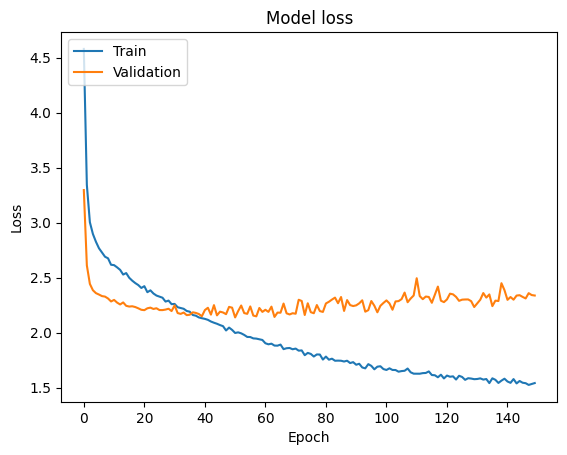

In [71]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

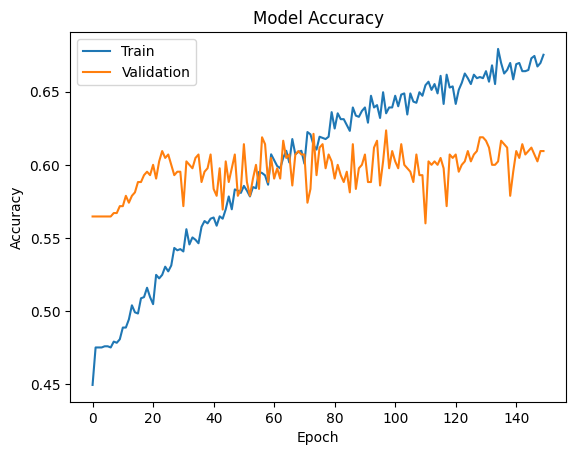

In [72]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [73]:
# Perform prediction for the first 200 rows one sample at a time
num_samples = min(200,len(x_test_main)) # Limit to the first 200 rows

predictions = []

for i in range(num_samples):
    single_x_test = x_test_main[i:i+1]
    single_y_test = y_test_main[i:i+1, :-1]  # Exclude last token
    print(single_x_test)
    single_prediction = model.predict([single_x_test, single_y_test])
    predictions.append(single_prediction)

# Concatenate predictions
predictions = np.concatenate(predictions, axis=0)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  169 104   2 170  65  36  28]]
1/1 [==============================] - 1s 549ms/step
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    1 141  18  12  85  15   2]]
1/1 [==============================] - 0s 20ms/step
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1 19 15  5 35 19 37 24 25 22
   5]]
1/1 [==============================] - 0s 35ms/step
[[  0   0   0   0   0   0   0   0   0   0   0   0   1  19  79  30   2 129
   49  11  19  80   1  17   9]]
1/1 [==============================] - 0s 23ms/step
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   8   1
   70   3 106  14  67 198 199]]
1/1 [==============================] - 0s 23ms/step
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  33 104
   67 181  14 182 105 183 184]]
1/1 [==============================] - 0s 22ms/step
[[  0   0   0   0   0   0   0  29  17  13   9  41 230  74  13 231  59  22
  

In [95]:
len(predictions)

10

In [74]:
def decode_prediction(prediction, tokenizer):
    # Get the index of the token with the highest probability for each time step
    token_indices = np.argmax(prediction, axis=-1)
    # Convert token indices to words using the tokenizer, handling out-of-vocabulary indices
    words = [tokenizer.index_word.get(index, '') for index in token_indices]  # Exclude padding token
    # Join the words into a single sentence
    sentence = ' '.join(words)
    return sentence

# Decode each prediction and print the corresponding Hindi sentences
for i, prediction in enumerate(predictions):
    decoded_sentence = decode_prediction(prediction,uk)
    print(f"Predicted Hindi sentence {i+1}: {decoded_sentence}")

Predicted Hindi sentence 1:                พระเจ้า พระเจ้า พระเจ้า สว่าง ต้น มนุษย์ เนื้อ อากาศ กิน เนื้อ
Predicted Hindi sentence 2:                  พระเจ้า สร้าง สว่าง พระองค์ สว่าง สว่าง สว่าง สว่าง
Predicted Hindi sentence 3:                พระเจ้า พระเจ้า สร้าง พระเจ้า สร้าง พระเจ้า บรรดา เย็น เวลา เช้า
Predicted Hindi sentence 4:             พระเจ้า พระเจ้า พระเจ้า พระเจ้า พระเจ้า พระเจ้า สว่าง สว่าง ต้น เนื้อ ดวง ดวง สอง
Predicted Hindi sentence 5:               พระเจ้า พระเจ้า พระเจ้า พระเจ้า พระเจ้า สร้าง สว่าง พระองค์ มนุษย์ พระองค์ พระองค์
Predicted Hindi sentence 6:                พระเยโฮวาห์ พระเจ้า สาย ไหล รอบ น้ำ พระองค์ ทองคำ สาย ดวง
Predicted Hindi sentence 7:          ไม้ สวน สวน แผ่นดิน แผ่นดิน โลก แผ่นดิน ไม้ ชีวิต ไม้ แผ่นดิน แผ่นดิน ไม้ ไม้ ต้น ไม้
Predicted Hindi sentence 8:                พระเจ้า พระเจ้า สว่าง อากาศ น้ำ น้ำ อากาศ น้ำ น้ำ ดวง
Predicted Hindi sentence 9:                    พระเจ้า พระเจ้า สร้าง   แผ่นดิน
Predicted Hindi sentence 10:              

In [75]:
word = []
for k in y_test_main:
    for i in k:
        if (i != 0):
            word.append(uk.index_word.get(i))
    print(word)
    word = []
print(len(y_test_main))

['หมอก', 'แผ่นดิน', 'โลก', 'ทำ', 'พื้น', 'แผ่นดิน', 'เปียก', 'ทั่วไป']
['พระเจ้า', 'ตั้งดวง', 'สว่าง', 'พื้นฟ้าอากาศ', 'ส่อง', 'สว่าง', 'แผ่นดิน', 'โลก']
['พระเจ้า', 'สว่าง', 'พระองค์', 'มืด', 'คืน', 'เวลา', 'เย็น', 'เวลา', 'เช้า']
['พระเจ้า', 'แห้ง', 'แผ่นดิน', 'น้ำ', 'รวบรวม', 'ทะเล', 'พระเจ้า', 'ดี']
['พระเยโฮวาห์', 'พระเจ้า', 'มนุษย์', 'สวน', 'เอเดน', 'ดูแล', 'รักษา', 'สวน']
['แม่น้ำ', 'สาย', 'ไหล', 'เอเดนรด', 'สวน', 'แยก', 'แม่น้ำ', 'สี่', 'สาย']
['ล้ม', 'บาป', 'มนุษย์', 'หญิง', 'ต้น', 'ไม้', 'เหมาะ', 'สำหรับ', 'อาหาร', 'งาม', 'ดู', 'ต้น', 'ไม้', 'ต้น', 'ปรารถนา', 'ปัญญา', 'หญิง', 'ผลไม้', 'กิน', 'สามี', 'กิน']
['สอง', 'เมฆ', 'เหนือ', 'ผิว', 'น้ำ', 'พระเจ้าตรัสว่า', 'พื้น', 'อากาศ', 'น้ำ', 'พื้น', 'อากาศ', 'แยก', 'น้ำ', 'น้ำ']
['พระเยโฮวาห์', 'พระเจ้า', 'อาดัม', 'ตรัส', 'เขาว่า', 'เจ้า']
['เวลา', 'เย็น', 'เวลา', 'เช้า', 'สาม']
['หก', 'ชาย', 'หญิง', 'คู่', 'พระเจ้าตรัสว่า', 'สร้าง', 'มนุษย์', 'ฉายา', 'ครอบครอง', 'ฝูง', 'ปลา', 'ทะเล', 'ฝูง', 'นก', 'อากาศ', 'สัตว์', 'งาน', 'ครอบครอง'

In [94]:
word = []
for k in x_test_main:
    for i in k:
        if (i != 0):
            word.append(u.index_word.get(i))
    print(word)
    word = []
print(len(y_test_main))

['therefore', 'a', 'man', 'will', 'leave', 'his', 'father', 'and', 'his', 'mother', 'and', 'will', 'join', 'with', 'his', 'wife', 'and', 'they', 'will', 'be', 'one', 'flesh']
['the', 'eyes', 'of', 'both', 'of', 'them', 'were', 'opened', 'and', 'they', 'knew', 'that', 'they', 'were', 'naked', 'they', 'sewed', 'fig', 'leaves', 'together', 'and', 'made', 'themselves', 'aprons']
['in', 'the', 'beginning', 'god', 'created', 'the', 'heavens', 'and', 'the', 'earth']
['yahweh', 'god', 'took', 'the', 'man', 'and', 'put', 'him', 'into', 'the', 'garden', 'of', 'eden', 'to', 'dress', 'it', 'and', 'to', 'keep', 'it']
['god', 'said', 'let', 'there', 'be', 'an', 'expanse', 'in', 'the', 'middle', 'of', 'the', 'waters', 'and', 'let', 'it', 'divide', 'the', 'waters', 'from', 'the', 'waters']
['they', 'heard', 'the', 'voice', 'of', 'yahweh', 'god', 'walking', 'in', 'the', 'garden', 'in', 'the', 'cool', 'of', 'the', 'day', 'and', 'the', 'man', 'and', 'his', 'wife', 'hid', 'themselves', 'from', 'the', 'pre